We have seen how to write a training loop to train the model and save the result in model parameters. The saved model can be used in multiple places, such as to continue training, to fine tune the model and for prediction. 

In [1]:
from mxnet import nd, gluon, metric

from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms

import matplotlib.pyplot as plt

## Build the model

To start, we will copy the same model definition as before. We recreate the similar net model used for training here.

In practice, you can write your model definition in a separate Python file, and import it for training and evaluation.

We need the model so that we can attach the train model parameters to the model architecture.

In [3]:
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation='relu'),
        nn.Dense(84, activation='relu'),
        nn.Dense(10)
    )

## Load the parameters

To load parameters to a network from an params file, we can simply use the load parameters method of the network or any gluon block.

In [4]:
net.load_parameters('trained_net.params')

## Predict

We will evaluate the trained model by running some predictions with it.

### Validation Dataset

Before we can run predictions, we need a dataset, specifically one that model has not yet seen. We can use the validation or test splits of the FashionMNIST dataset for our valuation. We can select it by setting the train keyword argument to false.


In [5]:
mnist_valid = datasets.FashionMNIST(train=False)

### Data Transformation

In [6]:
transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)
])

## Predict

### Predict first 6 images

Now, let's try to predict the first six images in the validation dataset, and stop predictions into preds. To do this, we iterate over each image that we want to predict. First, we apply the transformation and add an extra dimension for the batch size that our network is expected. Next, we get the network predictions for each class, and we can take the argmax to get the class that the network assigns the IRS confidence to. We can then start the prediction so that we can compare it to the validation level. 

In [22]:

preds = []
images = []
labels = []
for idx in range(6):
    image, label = mnist_valid[idx]
    images.append(image)
    labels.append(label)
    image = transform_fn(image).expand_dims(axis=0)
    pred = net(image).argmax(axis=1)
    preds.append(pred.astype('int32').asscalar())

We can visualize the images that we predicted and the ground truth label at the top compared to the network predictions at the bottom.

In [30]:
def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def plot_images(X, y, y_hat):
    images_count = len(X)
    labels = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(y_hat)
    fig, axes = plt.subplots(1,images_count, figsize=(10, 4))
    # fig.suptitle(title, fontsize=20)
    for ax, idx in zip(axes, range(images_count)):
        ax.imshow(X[idx].asnumpy())
        ax.set_title(f'{labels[idx]} \n {preds[idx]}')
        # ax.set_title()
        ax.axis('off')
  

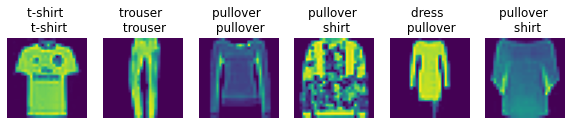

In [31]:
plot_images(images, labels, preds)

In [26]:
labels

[0, 1, 2, 2, 3, 2]

## Validation DataLoader

we just evaluated the model on a subset of the validation data. To use the entire validation dataset, we can create a validation data load just like we did during training. We said a batch size of 256 similar to the train data loader, and apply the same transformation. But we do not have to shuffle because we're not training the network

In [32]:
batch_size = 256
valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transform_fn),
    batch_size, num_workers=4
)

## Accuracy

We also need to define the metric we will be using to evaluate the model performance. Since we used accuracy during training, we will use the same for validation. We can simply use the accuracy metrics class from the MXNet Package. 

In [33]:
valid_acc = metric.Accuracy()

## Validation Loop

Now, we can implement the complete validation loop. We just need to go through the validation data load or wants unlike in training where we perform multiple a batch. For each batch of data and the validation dataset, we use the model to make a batch of predictions. We can then compute the accuracy of the model using the model's output and the ground truth validation liberal. Sum in this for each batch, and dividing by the number of batches, gives the models average accuracy. For the model that we trained, we can see that the validation accuracy of 89.4 percent is very close to the training accuracy of 90 percent. Meaning that the model does a good job generalizing to new examples. 

In [34]:
for data, label in valid_data:
    output = net(data)
    valid_acc.update(label, output)

print(f'Validation Acc: {valid_acc.get()[1]:.3f}')

Validation Acc: 0.894
